# Train and infer

In [ ]:
import torch
from vector_quantize_pytorch import ResidualVQ
import polars as pl
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


# === Paths and constants ===
PATH = "D:/finetune_sbert_new/1Membeddings/"
EMBEDDING_PATH = PATH + "result_embeddings/sapbert_lora_triplet16.pt"
CONCEPT_PARQUET = PATH + "concept_all.parquet"
MAPPED_CSV = PATH + "mapped_concepts_2025-04-01.csv"
alpha = 10
num_epochs = 100

seed = 1234
lr = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)


# === Load data ===
df_concept_all = pl.read_parquet(CONCEPT_PARQUET)
df_mapped = pl.read_csv(MAPPED_CSV)
idx_mapped = df_mapped.join(df_concept_all, left_on="n.id", right_on="id")['idx'].unique().to_list()

# === Load and filter embeddings ===
embeddings = torch.load(EMBEDDING_PATH)['labels_embeddings']  # [N, 768]
embedding_mapped = embeddings[idx_mapped, :]  # [N', 768]

# === Dataset & DataLoader ===
dataset = TensorDataset(embedding_mapped)
train_loader = DataLoader(dataset, batch_size=256*8, shuffle=True)


In [2]:

# === Initialize RVQ model ===
model = ResidualVQ(
    dim=768,
    codebook_size=1000,
    num_quantizers=6,
    # kmeans_init=True,
    # kmeans_iters=10,
    learnable_codebook=True,
    ema_update=False,
    use_cosine_sim=True
).to(device)

# === Optimizer ===

def train(model, train_loader, num_epochs=1000, alpha=0):
    train_loss = []
    
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    model.train()

    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")

        for x_batch in train_loader:

            x = x_batch[0].to(device)
            opt.zero_grad()

            out, indices, _ = model(x)
            # out = out.clamp(-1., 1.)

            # rec_loss = torch.mean((x-out)**2) 
            rec_loss = 1 - F.cosine_similarity(x, out, dim=-1).mean()
            train_loss.append(rec_loss.item())
            rec_loss.backward()
            opt.step()

            print(f"loss: {rec_loss}")

    return model, train_loss

# === Run training ===
model, loss = train(model, train_loader, num_epochs=num_epochs, alpha=alpha)


=== Epoch 1/100 ===
loss: 0.7204274535179138
loss: 0.7170251607894897
loss: 0.7138837575912476
loss: 0.7097214460372925
loss: 0.7054417729377747
loss: 0.7019229531288147
loss: 0.6980310678482056
loss: 0.6941422820091248
loss: 0.6895906925201416
loss: 0.6854498982429504
loss: 0.6821843385696411
loss: 0.6770488619804382
loss: 0.6743835210800171
loss: 0.6698390245437622
loss: 0.6655766367912292
loss: 0.6620840430259705
loss: 0.6576241850852966
loss: 0.6527905464172363
loss: 0.6510341167449951

=== Epoch 2/100 ===
loss: 0.6414510011672974
loss: 0.6371709108352661
loss: 0.6317680478096008
loss: 0.6282886862754822
loss: 0.6267334222793579
loss: 0.62245774269104
loss: 0.6174498796463013
loss: 0.6150684356689453
loss: 0.6106787919998169
loss: 0.6076827645301819
loss: 0.603090226650238
loss: 0.5974411964416504
loss: 0.5948163270950317
loss: 0.5937602519989014
loss: 0.5912126898765564
loss: 0.583909273147583
loss: 0.5809476971626282
loss: 0.576845109462738
loss: 0.5732071399688721

=== Epoch 3/

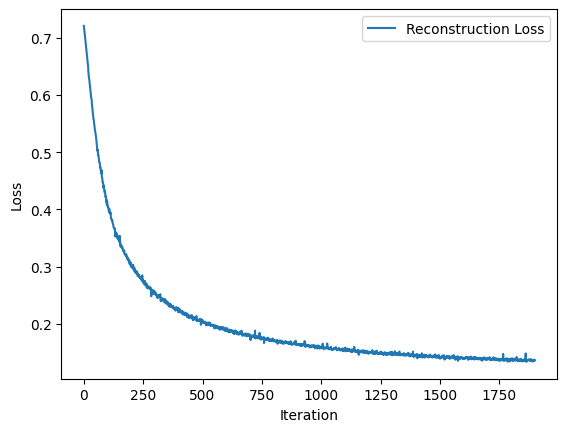

In [3]:
import matplotlib.pyplot as plt
plt.plot(loss, label='Reconstruction Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
model.eval()
with torch.no_grad():

    embeddings = embeddings.to(device)

    quantized, indices_all, _ = model(embeddings)
    cos_sim = F.cosine_similarity(embeddings, quantized, dim=-1)    
    print("Average cosine similarity:", cos_sim.mean().item()) 

Average cosine similarity: 0.7133999466896057


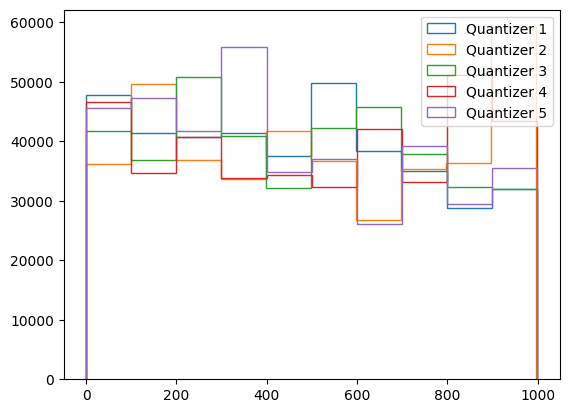

In [5]:
for i in range(5):
    plt.hist(indices_all.cpu().squeeze(0)[:,i], histtype="step")
    plt.legend([f"Quantizer {i+1}" for i in range(5)], loc='upper right')

In [6]:
print(torch.unique(indices_all,dim=0).shape)
print(indices_all.shape)
print(torch.unique(indices_all,dim=0).shape[0] / indices_all.shape[0])

torch.Size([349883, 6])
torch.Size([392641, 6])
0.8911015405930608


In [7]:
model.eval()
with torch.no_grad():
    embedding_mapped = embedding_mapped.to(device)

    quantized_mapped, indices_mapped, _ = model(embedding_mapped)
    cos_sim = F.cosine_similarity(embedding_mapped, quantized_mapped, dim=-1)
    print("Average cosine similarity:", cos_sim.mean().item()) 

Average cosine similarity: 0.8647537231445312


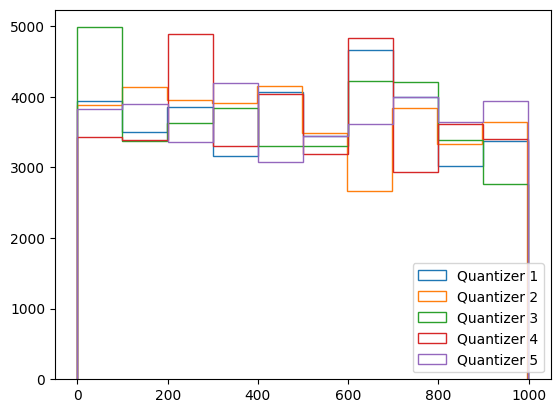

In [8]:
for i in range(5):
    plt.hist(indices_mapped.cpu().squeeze(0)[:,i], histtype="step")
    plt.legend([f"Quantizer {i+1}" for i in range(5)], loc='lower right')

In [37]:
print(torch.unique(indices_mapped,dim=0).shape)
print(indices_mapped.shape)
print(torch.unique(indices_mapped,dim=0).shape[0] / indices_mapped.shape[0])


torch.Size([36082, 6])
torch.Size([37006, 6])
0.975031076041723


# get embeddings and add in the dict

In [ ]:
embedding_data = torch.load(EMBEDDING_PATH)


In [ ]:
torch.save({
    "labels": embedding_data["labels"],
    "labels_embeddings": embedding_data["labels_embeddings"],
    "quantized_labels_embeddings": quantized.cpu()
}, "sapbert_lora_triplet16_quantized.pt")
